# Importing all the Libraries

In [38]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Reading the 4 Separate sheets of the xlsx dataset

In [2]:
Customers = pd.read_excel('C:\\Users\\tejan\\Downloads\\Data_Intern_Case_Data.xlsx', sheet_name='Customers')
PolicyDetails = pd.read_excel('C:\\Users\\tejan\\Downloads\\Data_Intern_Case_Data.xlsx', sheet_name='PolicyDetails')
Claims = pd.read_excel('C:\\Users\\tejan\\Downloads\\Data_Intern_Case_Data.xlsx', sheet_name='Claims')
Fraud = pd.read_excel('C:\\Users\\tejan\\Downloads\\Data_Intern_Case_Data.xlsx', sheet_name='Fraud')
print("Column headings:")
print(Customers.columns)
print(PolicyDetails.columns)
print(Claims.columns)
print(Fraud.columns)

Column headings:
Index(['CustomerID', 'State', 'Salary', 'Gender', 'Smoker', 'Age',
       'Occupation'],
      dtype='object')
Index(['PolicyID', 'CustomerID', 'Agent', 'Elimination Period',
       'Income Replacement Percent', 'Monthly Benefit', 'Annualized Premium',
       'Product', 'Policy Effective Date'],
      dtype='object')
Index(['PolicyID', 'Date of Loss', 'Diagnosis Category',
       'Length of Disability (in Days)', 'Fraud', 'Amount Paid',
       'Amount Recovered'],
      dtype='object')
Index(['PolicyID', 'Fraud', 'Amount Paid', 'Amount Recovered'], dtype='object')


# As asked in the problem statement, only considering those cases that have a Disability insurance product brought

In [3]:
PolicyDetails = PolicyDetails.query('Product == "Disability"')

# Merging the Customers data and Policydetails data on "CustomerID"

In [4]:
df1 = pd.merge(Customers, PolicyDetails, on = "CustomerID", how = "inner")

In [5]:
df1.shape

(30838, 15)

# Merging the data with Fraud data on "PolicyID"

In [6]:
df2 =pd.merge(df1, Fraud, on = "PolicyID", how = "inner")

# Dropping the duplicate rows, by keeping the first instance of the duplicate rows

In [7]:
df2.drop_duplicates(keep = "first", inplace = True)

# Dropping the irrelevant columns like date variables, IDs, and variables that realize after the target variable

In [8]:

df2.drop(columns = ["CustomerID", "PolicyID", "Policy Effective Date", "Product", "Amount Recovered", "State"], axis = 1, inplace = True)

In [9]:
df2.head()

,Salary,Gender,Smoker,Age,Occupation,Agent,Elimination Period,Income Replacement Percent,Monthly Benefit,Annualized Premium,Fraud,Amount Paid
0,43916.0,1,1,36,Teacher,Alicia Purple,14 days,0.67,2452.0,2118.52800,1,20433.333333
2,62139.0,0,0,41,Teacher,Alicia Purple,30 days,0.67,3469.0,1398.70080,1,52150.633333
4,36989.0,0,1,44,Teacher,Max Colorado,14 days,0.67,2065.0,1784.16000,1,10600.333333
6,42800.0,0,0,50,Teacher,Max Colorado,45 days,0.50,1783.0,684.67200,1,19315.833333
8,42681.0,0,0,43,Teacher,Nico Vulture,30 days,0.67,2383.0,1152.99072,1,9134.833333


# Looking at the summary statistics of the data, to get an idea about the data distribution

In [10]:
df2.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Salary,30838,NaN,NaN,NaN,46562.2,12676.2,14102,38424.5,47720.5,55411.2,300000
Gender,30838,NaN,NaN,NaN,0.512031,0.499863,0,0,1,1,1
Smoker,30838,NaN,NaN,NaN,0.250243,0.43316,0,0,0,1,1
Age,30838,NaN,NaN,NaN,45.9192,7.95455,18,41,46,51,79
Occupation,30838,11,Teacher,17322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agent,30838,5,Alicia Purple,11877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Period,30838,3,14 days,17206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income Replacement Percent,30838,NaN,NaN,NaN,0.640903,0.0684406,0.5,0.67,0.67,0.67,0.7
Monthly Benefit,30838,NaN,NaN,NaN,2486.69,732.374,531,1970,2526,3009,17500
Annualized Premium,30838,NaN,NaN,NaN,1696.42,883.582,178.464,1014.52,1564.42,2209.54,9878.4


# Checking for any null values - There are none

In [11]:
df2.isnull().sum()

Salary                        0
Gender                        0
Smoker                        0
Age                           0
Occupation                    0
Agent                         0
Elimination Period            0
Income Replacement Percent    0
Monthly Benefit               0
Annualized Premium            0
Fraud                         0
Amount Paid                   0
dtype: int64

# The final data has 30,838 rows and 12 columns

In [12]:
df2.shape

(30838, 12)

# There is a class imbalance in the data, Event proportion is 14.78% and non event proportion is 85.22% in the binary Target

In [13]:
df2.Fraud.value_counts(normalize = True)

0    0.85213
1    0.14787
Name: Fraud, dtype: float64

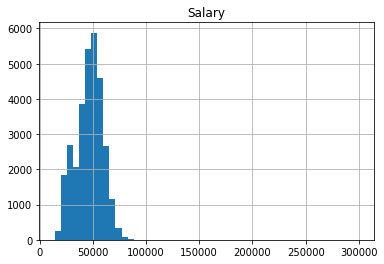

In [51]:
ax = df1.hist("Salary", bins = 50)

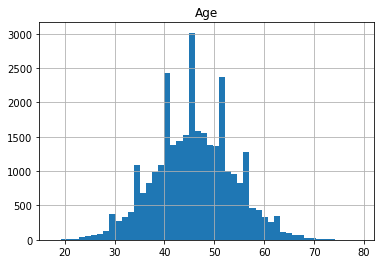

In [52]:
ax = df1.hist("Age", bins = 50)

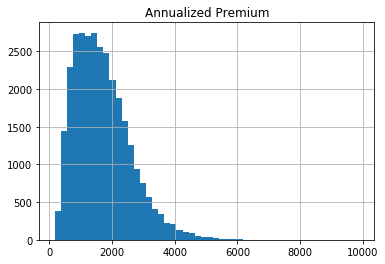

In [53]:
ax = df1.hist("Annualized Premium", bins = 50)

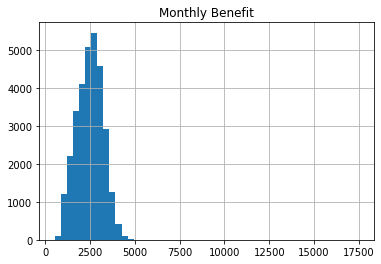

In [55]:
ax = df1.hist("Monthly Benefit", bins = 50)

# Identifying continuous columns and categorical columns based on my understanding of the data

In [14]:
Cont_cols = ['Salary', 'Age', 'Monthly Benefit', 'Annualized Premium', 'Amount Paid']
Cat_cols = [  'Occupation', 'Agent', 'Elimination Period', 'Income Replacement Percent']

# Standard scaling the continuous variables to make them have equal impact in the modeling process

In [15]:
scaler = preprocessing.StandardScaler()
for col in Cont_cols:
    df2[col] = scaler.fit_transform(df2[col].values.reshape(-1,1))  

# Converting the categorical colums to category and then, encoding them to numeric variables, then dropping the original variables

In [16]:
for col in Cat_cols:
    df2[col] = df2[col].astype('category')

In [17]:
dum1_df2 = pd.get_dummies(df2['Occupation'] )
dum2_df2 = pd.get_dummies(df2["Agent"] )
dum3_df2 = pd.get_dummies(df2["Elimination Period"] )
dum4_df2 = pd.get_dummies(df2["Income Replacement Percent"])

In [132]:
# dum4_df2 = dum4_df2.reset_index()
# dum4_df2.drop(columns = ["index"], axis = 1)
# dum1_df2 = dum1_df2.reset_index()
# dum1_df2.drop(columns = ["index"], axis = 1)
# dum2_df2 = dum2_df2.reset_index()
# dum2_df2.drop(columns = ["index"], axis = 1)
# dum3_df2 = dum3_df2.reset_index()
# dum3_df2.drop(columns = ["index"], axis = 1)

In [18]:
df2 = pd.concat([df2, dum1_df2], axis = 1)
df2 = pd.concat([df2, dum2_df2], axis = 1)
df2 = pd.concat([df2, dum3_df2], axis = 1)
df2 = pd.concat([df2, dum4_df2], axis = 1)

In [21]:
df2.drop(columns = ['Agent', 'Elimination Period', 'Occupation','Income Replacement Percent'], axis = 1, inplace = True)

# Separating the data to input data and target data

In [27]:
X = df2.loc[:, df2.columns != 'Fraud'].values
y = df2['Fraud'].values.reshape(-1)

# Splitting the data to training and validation data, doing a validation prportion of 20% and using a stratified split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

# Oversampling the training data using SMOTETomek technique

In [29]:
smt = SMOTETomek(random_state=123)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

print('Original training dataset shape %s' % Counter(y_train))
print('Original testing dataset shape %s' % Counter(y_test))
print('SmoteTomek dataset shape %s' % Counter(y_smt))

Original training dataset shape Counter({0: 21022, 1: 3648})
Original testing dataset shape Counter({0: 5256, 1: 912})
SmoteTomek dataset shape Counter({0: 20369, 1: 20369})


# Since all the data is numeric, we can use Naive Bayes classifier from sklearn to do the classification between Fraud and non-Fraud cases

In [56]:
gnb = GaussianNB() 
gnb.fit(X_smt, y_smt) 
print("Gaussian Naive Bayes testing model accuracy(in %):", metrics.accuracy_score(y_test, gnb.predict(X_test) )*100)
print("Gaussian Naive Bayes training model accuracy(in %):", metrics.accuracy_score(y_smt, gnb.predict(X_smt) )*100)

Gaussian Naive Bayes testing model accuracy(in %): 51.11867704280155
Gaussian Naive Bayes training model accuracy(in %): 66.71412440473267


# Note that the low accuracy on the testing data is may be caused by overfitting. Classification report shows the precision, recall, f1 score on the validation data

In [57]:
print(classification_report(y_test, gnb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.46      0.61      5256
           1       0.21      0.83      0.34       912

    accuracy                           0.51      6168
   macro avg       0.58      0.64      0.47      6168
weighted avg       0.83      0.51      0.57      6168



In [58]:
print(classification_report(y_smt, gnb.predict(X_smt)))

              precision    recall  f1-score   support

           0       0.78      0.47      0.58     20369
           1       0.62      0.87      0.72     20369

    accuracy                           0.67     40738
   macro avg       0.70      0.67      0.65     40738
weighted avg       0.70      0.67      0.65     40738



# We have a good recall and a not so good precision. Lets look at the ROC curve. ROC of 0.69 is a decent one

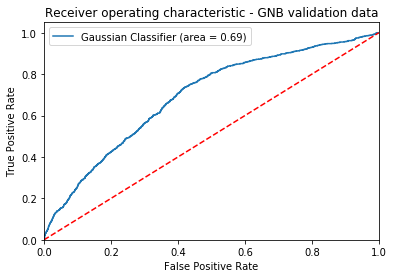

<Figure size 432x288 with 0 Axes>

In [147]:
roc_auc = roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GNB validation data')
plt.legend(loc="upper left")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

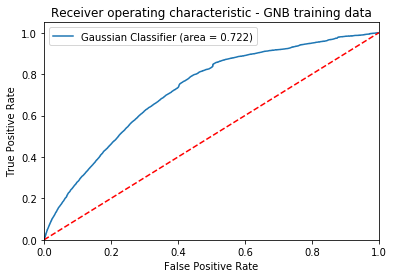

<Figure size 432x288 with 0 Axes>

In [61]:
roc_auc = roc_auc_score(y_smt, gnb.predict_proba(X_smt)[:,1])
fpr, tpr, thresholds = roc_curve(y_smt, gnb.predict_proba(X_smt)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian Classifier (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GNB training data')
plt.legend(loc="upper left")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

# Lets do KNN. Since 'k' is a hyper parameter, I have plotted the accuracy, recall and precision values of the model for all values of k from 1 to 100

In [37]:
accuracy = {}
precision = {}
recall = {}
accuracy_list = []
precision_list = []
recall_list = []

for k in range(1,101):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_smt, y_smt)
    y_pred = neigh.predict(X_test)
    accuracy[k] = accuracy_score(y_test, y_pred)
    recall[k] = recall_score(y_test, y_pred)
    precision[k] = precision_score(y_test, y_pred)
    accuracy_list.append(accuracy[k])
    recall_list.append(recall[k])
    precision_list.append(precision[k])


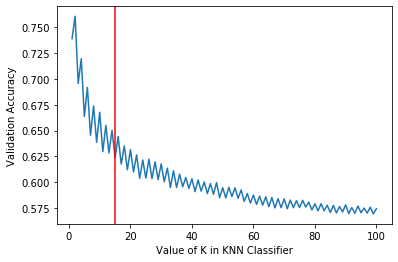

In [62]:
k = range(1,101)
plt.plot(k , accuracy_list)
plt.xlabel("Value of K in KNN Classifier")
plt.ylabel("Validation Accuracy")
plt.axvline(15,0,1, c = "red")

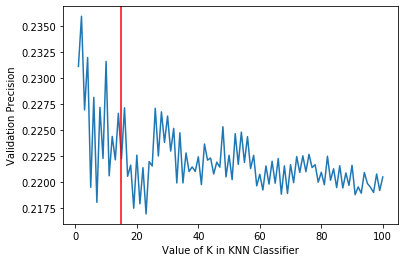

In [63]:
plt.plot(k , precision_list)
plt.xlabel("Value of K in KNN Classifier")
plt.ylabel("Validation Precision")
plt.axvline(15,0,1, c = "red")

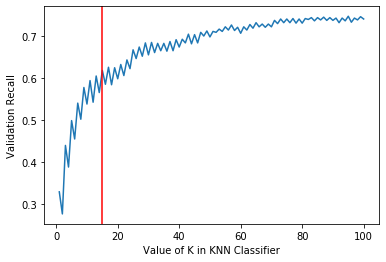

In [64]:
plt.plot(k , recall_list)
plt.xlabel("Value of K in KNN Classifier")
plt.ylabel("Validation Recall")
plt.axvline(15,0,1, c = "red")

In [69]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_smt, y_smt)
y_pred = neigh.predict(X_test)
y_pred_train = neigh.predict(X_smt)
print("test accuracy", accuracy_score(y_test, y_pred))
print("training accuracy", accuracy_score(y_smt,neigh.predict(X_smt)))
print("The classification report on training data is \n")
print(classification_report(y_smt, neigh.predict(X_smt)))
print("The classification report on test data is \n")
print(classification_report(y_test, neigh.predict(X_test)))
print("The training data metrics are -")
print(f'Accuracy: {neigh.score(X_smt, y_smt)}')
print(f'f-score: {f1_score(y_smt, y_pred_train)}')
print(f'recall: {recall_score(y_smt, y_pred_train)}')
print(f'precision: {precision_score(y_smt, y_pred_train)}')
print("The validation data metrics are -")
print(f'Accuracy: {neigh.score(X_test, y_test)}')
print(f'f-score: {f1_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')

test accuracy 0.6235408560311284
validation accuracy 0.8053659973489126
The classification report on training data is 

              precision    recall  f1-score   support

           0       0.91      0.68      0.78     20369
           1       0.74      0.93      0.83     20369

    accuracy                           0.81     40738
   macro avg       0.83      0.81      0.80     40738
weighted avg       0.83      0.81      0.80     40738

The classification report on test data is 

              precision    recall  f1-score   support

           0       0.90      0.62      0.74      5256
           1       0.22      0.62      0.33       912

    accuracy                           0.62      6168
   macro avg       0.56      0.62      0.53      6168
weighted avg       0.80      0.62      0.68      6168

The training data metrics are -
Accuracy: 0.8053659973489126
f-score: 0.8270476605954848
recall: 0.9307280671608817
precision: 0.7441513581409954
The validation data metrics are -
Ac

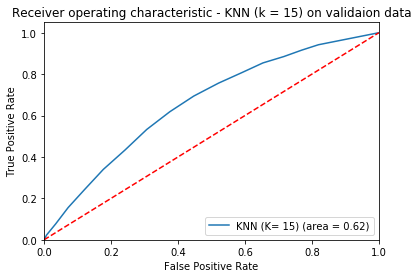

<Figure size 432x288 with 0 Axes>

In [73]:
roc_auc = roc_auc_score(y_test, neigh.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (K= 15) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - KNN (k = 15) on validaion data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

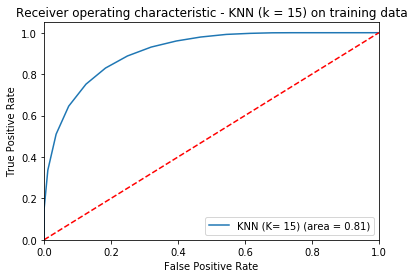

<Figure size 432x288 with 0 Axes>

In [72]:
roc_auc = roc_auc_score(y_smt, neigh.predict(X_smt))
fpr, tpr, thresholds = roc_curve(y_smt, neigh.predict_proba(X_smt)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (K= 15) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - KNN (k = 15) on training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

# Lets do SVM. I will try out different kernals like sigmoid, rbf, etc.

In [74]:
svm_clf = SVC(kernel='sigmoid', C = 0.1)
svm_clf.fit(X_smt, y_smt)
y_pred = svm_clf.predict(X_test)
y_pred_train = svm_clf.predict(X_smt)
print("test accuracy", accuracy_score(y_test,y_pred))
print("training accuracy", accuracy_score(y_smt,svm_clf.predict(X_smt)))
print("The classification report on training data is \n")
print(classification_report(y_smt, svm_clf.predict(X_smt)))
print("The classification report on test data is \n")
print(classification_report(y_test, svm_clf.predict(X_test)))

print("The training data metrics are -")
print(f'Accuracy: {svm_clf.score(X_smt, y_smt)}')
print(f'f-score: {f1_score(y_smt, y_pred_train)}')
print(f'recall: {recall_score(y_smt, y_pred_train)}')
print(f'precision: {precision_score(y_smt, y_pred_train)}')
print("The validation data metrics are -")
print(f'Accuracy: {svm_clf.score(X_test, y_test)}')
print(f'f-score: {f1_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')

test accuracy 0.5496108949416343
training accuracy 0.5472777259561098
The classification report on training data is 

              precision    recall  f1-score   support

           0       0.55      0.55      0.55     20369
           1       0.55      0.55      0.55     20369

    accuracy                           0.55     40738
   macro avg       0.55      0.55      0.55     40738
weighted avg       0.55      0.55      0.55     40738

The classification report on test data is 

              precision    recall  f1-score   support

           0       0.88      0.55      0.67      5256
           1       0.18      0.56      0.27       912

    accuracy                           0.55      6168
   macro avg       0.53      0.56      0.47      6168
weighted avg       0.78      0.55      0.61      6168

The training data metrics are -
Accuracy: 0.5472777259561098
f-score: 0.5479324460131872
recall: 0.5487260052039864
precision: 0.5471411787742314
The validation data metrics are -
Accu

In [78]:
svm_clf = SVC(kernel='sigmoid', C = 0.01)
svm_clf.fit(X_smt, y_smt)
y_pred = svm_clf.predict(X_test)
y_pred_train = svm_clf.predict(X_smt)
print("test accuracy", accuracy_score(y_test,y_pred))
print("training accuracy", accuracy_score(y_smt,svm_clf.predict(X_smt)))
print("The classification report on training data is \n")
print(classification_report(y_smt, svm_clf.predict(X_smt)))
print("The classification report on test data is \n")
print(classification_report(y_test, svm_clf.predict(X_test)))

print("The training data metrics are -")
print(f'Accuracy: {svm_clf.score(X_smt, y_smt)}')
print(f'f-score: {f1_score(y_smt, y_pred_train)}')
print(f'recall: {recall_score(y_smt, y_pred_train)}')
print(f'precision: {precision_score(y_smt, y_pred_train)}')
print("The validation data metrics are -")
print(f'Accuracy: {svm_clf.score(X_test, y_test)}')
print(f'f-score: {f1_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')

test accuracy 0.5964656290531777
training accuracy 0.615518680347587
The classification report on training data is 

              precision    recall  f1-score   support

           0       0.62      0.60      0.61     20369
           1       0.61      0.63      0.62     20369

    accuracy                           0.62     40738
   macro avg       0.62      0.62      0.62     40738
weighted avg       0.62      0.62      0.62     40738

The classification report on test data is 

              precision    recall  f1-score   support

           0       0.89      0.60      0.72      5256
           1       0.20      0.59      0.30       912

    accuracy                           0.60      6168
   macro avg       0.55      0.59      0.51      6168
weighted avg       0.79      0.60      0.65      6168

The training data metrics are -
Accuracy: 0.615518680347587
f-score: 0.62015278283012
recall: 0.6277185919780058
precision: 0.6127671810600978
The validation data metrics are -
Accuracy

In [75]:
svm_clf = SVC(kernel='rbf', C = 0.1)
svm_clf.fit(X_smt, y_smt)
y_pred = svm_clf.predict(X_test)
y_pred_train = svm_clf.predict(X_smt)
print("test accuracy", accuracy_score(y_test,y_pred))
print("training accuracy", accuracy_score(y_smt,svm_clf.predict(X_smt)))
print("The classification report on training data is \n")
print(classification_report(y_smt, svm_clf.predict(X_smt)))
print("The classification report on test data is \n")
print(classification_report(y_test, svm_clf.predict(X_test)))

print("The training data metrics are -")
print(f'Accuracy: {svm_clf.score(X_smt, y_smt)}')
print(f'f-score: {f1_score(y_smt, y_pred_train)}')
print(f'recall: {recall_score(y_smt, y_pred_train)}')
print(f'precision: {precision_score(y_smt, y_pred_train)}')
print("The validation data metrics are -")
print(f'Accuracy: {svm_clf.score(X_test, y_test)}')
print(f'f-score: {f1_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')

test accuracy 0.60473411154345
training accuracy 0.6931611762973146
The classification report on training data is 

              precision    recall  f1-score   support

           0       0.74      0.59      0.66     20369
           1       0.66      0.79      0.72     20369

    accuracy                           0.69     40738
   macro avg       0.70      0.69      0.69     40738
weighted avg       0.70      0.69      0.69     40738

The classification report on test data is 

              precision    recall  f1-score   support

           0       0.93      0.58      0.71      5256
           1       0.24      0.75      0.36       912

    accuracy                           0.60      6168
   macro avg       0.58      0.66      0.54      6168
weighted avg       0.83      0.60      0.66      6168

The training data metrics are -
Accuracy: 0.6931611762973146
f-score: 0.721491912125128
recall: 0.7948843831312288
precision: 0.6605066699302411
The validation data metrics are -
Accurac

In [77]:
svm_clf = SVC(kernel='rbf',  C = 0.3)
svm_clf.fit(X_smt, y_smt)
y_pred = svm_clf.predict(X_test)
y_pred_train = svm_clf.predict(X_smt)
print("test accuracy", accuracy_score(y_test,y_pred))
print("training accuracy", accuracy_score(y_smt,svm_clf.predict(X_smt)))
print("The classification report on training data is \n")
print(classification_report(y_smt, svm_clf.predict(X_smt)))
print("The classification report on test data is \n")
print(classification_report(y_test, svm_clf.predict(X_test)))

print("The training data metrics are -")
print(f'Accuracy: {svm_clf.score(X_smt, y_smt)}')
print(f'f-score: {f1_score(y_smt, y_pred_train)}')
print(f'recall: {recall_score(y_smt, y_pred_train)}')
print(f'precision: {precision_score(y_smt, y_pred_train)}')
print("The validation data metrics are -")
print(f'Accuracy: {svm_clf.score(X_test, y_test)}')
print(f'f-score: {f1_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')

test accuracy 0.6138132295719845
training accuracy 0.7032254897147626
The classification report on training data is 

              precision    recall  f1-score   support

           0       0.75      0.61      0.67     20369
           1       0.67      0.80      0.73     20369

    accuracy                           0.70     40738
   macro avg       0.71      0.70      0.70     40738
weighted avg       0.71      0.70      0.70     40738

The classification report on test data is 

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      5256
           1       0.24      0.73      0.36       912

    accuracy                           0.61      6168
   macro avg       0.58      0.66      0.54      6168
weighted avg       0.83      0.61      0.67      6168

The training data metrics are -
Accuracy: 0.7032254897147626
f-score: 0.7290209790209791
recall: 0.7984191663802838
precision: 0.6707221511939622
The validation data metrics are -
Accu